# Projet 7: Implémentez un modèle de scoring (feature selection et choix du modèle de scoring)

## Table des matières: <a class="anchor" id="0"></a>

1. [Import des librairies et configurations générales](#library)
2. [Chargement des données](#load)
3. [Sélection des données d'entrainement et de test](#train_test)
4. [Feature selection](#feats)
5. [Traitement des données déséquilibrées](#imbalanced)
6. [Pipeline, optimisation et entrainement des modèles](#pipe)
7. [Choix des scores](#scores)
8. [Modélisations](#model)
    1. [Modèle Baseline: Dummy classifier](#dummy)
    2. [Régression logistique](#reglog)




## Import des librairies et configurations générales <a class="anchor" id="library"></a>

In [1]:
# builtin
#import os
import time
#from os import listdir

# data
import numpy as np
import pandas as pd

# Fonctions personnelles
import fct_eda
import fct_preprocessing
import fct_model

# Update Fonctions personnelles
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# viz
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches
import seaborn as sns

# stats
#from scipy.stats import chi2_contingency #Chi2
#import pingouin as pg # Test Chi2 d'independance

# models
#from sklearn.experimental import enable_iterative_imputer
#from sklearn.impute import IterativeImputer
#from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Feature Selection
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif

# Balancing data
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as pipe

from sklearn.model_selection import train_test_split, cross_validate, KFold, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import set_config
set_config(display='diagram')
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, fbeta_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

#import joblib # sauvegarde des modèles
#from mlflow.models.signature import infer_signature
#from urllib.parse import urlparse
import mlflow
import mlflow.sklearn


#import gc
#from contextlib import contextmanager

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.filterwarnings('ignore')

#
#from sklearn.metrics import roc_auc_score, roc_curve
#from sklearn.model_selection import KFold, StratifiedKFold

In [2]:
# Configuration Pandas
pd_option_dictionary = {
    'display.max_rows': 500,
    'display.max_column': 200,
    'display.width': 300,
    'display.precision': 4,
    'display.max_colwidth': None,
    'display.float_format' : '{:.2f}'.format,
}

for pat, value in pd_option_dictionary.items():
    pd.set_option(pat, value)

## Chargement des données <a class="anchor" id="load"></a>

In [3]:
df = fct_preprocessing.preprocessing_no_NaN()

Application_train shape: (307505, 61)
Processing application_train fait en 9.0s 
Bureau shape: (305811, 19)
Processing bureau et bureau_balance fait en 26.0s 
Previous applications shape: (338857, 150)
Processing previous_applications fait en 53.0s 
Pos-cash balance shape: (337252, 3)
Processing POS-CASH balance fait en 9.0s 
Installments payments shape: (339587, 4)
Processing installments payments fait en 34.0s 
Credit card balance shape: (103558, 5)
Processing credit card balance fait en 57.0s 


In [4]:
# Vérification que le dataset consolidé ne contient pas de NaN
fct_eda.shape_total_nan(df)

Nombre de lignes: 307505
Nombre de colonnes: 237
Nombre total de NaN du dataset: 0
% total de NaN du dataset: 0.0%


In [5]:
df.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_11,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_18,CNT_FAM_MEMBERS_RANGE,AGE,AGE_RANGE,YEARS_EMPLOYED,YEARS_EMPLOYED_RANGE,YEARS_REGISTRATION,YEARS_REGISTRATION_RANGE,HOUR_APPR_PROCESS_START_RANGE,YEARS_ID_PUBLISH,YEARS_ID_PUBLISH_RANGE,YEARS_LAST_PHONE_CHANGE,YEARS_LAST_PHONE_CHANGE_RANGE,CREDIT_DURATION,DEBT_RATIO,PAYMENT_RATE,INCOME_PER_PERSON,INCOME_CREDIT_PERC,CREDIT_GOODS_PERC,BURO_AMT_CREDIT_SUM_SUM,BURO_AMT_CREDIT_SUM_MEAN,BURO_AMT_CREDIT_SUM_DEBT_SUM,BURO_AMT_CREDIT_SUM_DEBT_MEAN,BURO_YEARS_CREDIT_ENDDATE_MEAN,BURO_YEARS_CREDIT_ENDDATE_MAX,BURO_CREDIT_ACTIVE_Active_SUM,BURO_CREDIT_ACTIVE_Closed_SUM,BURO_CREDIT_ACTIVE_Sold / Bad Debt_SUM,BURO_CREDIT_TYPE_Car loan_SUM,BURO_CREDIT_TYPE_Consumer credit_SUM,BURO_CREDIT_TYPE_Credit card_SUM,BURO_CREDIT_TYPE_Microloan_SUM,BURO_CREDIT_TYPE_Mortgage_SUM,BURO_CREDIT_TYPE_Other_SUM,BURO_STATUS_Between 31 and 120 DPD_SUM_SUM,BURO_STATUS_Closed_SUM_SUM,BURO_STATUS_Max 30 DPD_SUM_SUM,BURO_STATUS_More than 120 DPD or written off_SUM_SUM,PREV_NB_CREDIT,PREV_YEARS_DECISION_MEAN,PREV_CREDIT_DURATION_MEAN,PREV_CREDIT_GOODS_PERC_MEAN,PREV_PAYMENT_RATE_MEAN,PREV_NAME_CONTRACT_TYPE_Cash loans_MEAN,PREV_NAME_CONTRACT_TYPE_Consumer loans_MEAN,PREV_NAME_CONTRACT_TYPE_Revolving loans_MEAN,PREV_NAME_CONTRACT_TYPE_XNA_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_FRIDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_MONDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_SATURDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_THURSDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_TUESDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Business development_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Buying a garage_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_MEAN,...,PREV_CODE_REJECT_REASON_XNA_MEAN,PREV_NAME_CLIENT_TYPE_New_MEAN,PREV_NAME_CLIENT_TYPE_Refreshed_MEAN,PREV_NAME_CLIENT_TYPE_Repeater_MEAN,PREV_NAME_CLIENT_TYPE_XNA_MEAN,PREV_NAME_GOODS_CATEGORY_Additional Service_MEAN,PREV_NAME_GOODS_CATEGORY_Animals_MEAN,PREV_NAME_GOODS_CATEGORY_Audio/Video_MEAN,PREV_NAME_GOODS_CATEGORY_Auto Accessories_MEAN,PREV_NAME_GOODS_CATEGORY_Clothing and Accessories_MEAN,PREV_NAME_GOODS_CATEGORY_Computers_MEAN,PREV_NAME_GOODS_CATEGORY_Construction Materials_MEAN,PREV_NAME_GOODS_CATEGORY_Consumer Electronics_MEAN,PREV_NAME_GOODS_CATEGORY_Direct Sales_MEAN,PREV_NAME_GOODS_CATEGORY_Education_MEAN,PREV_NAME_GOODS_CATEGORY_Fitness_MEAN,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,PREV_NAME_GOODS_CATEGORY_Gardening_MEAN,PREV_NAME_GOODS_CATEGORY_Homewares_MEAN,PREV_NAME_GOODS_CATEGORY_House Construction_MEAN,PREV_NAME_GOODS_CATEGORY_Insurance_MEAN,PREV_NAME_GOODS_CATEGORY_Jewelry_MEAN,PREV_NAME_GOODS_CATEGORY_Medical Supplies_MEAN,PREV_NAME_GOODS_CATEGORY_Medicine_MEAN,PREV_NAME_GOODS_CATEGORY_Mobile_MEAN,PREV_NAME_GOODS_CATEGORY_Office Appliances_MEAN,PREV_NAME_GOODS_CATEGORY_Other_MEAN,PREV_NAME_GOODS_CATEGORY_Photo / Cinema Equipment_MEAN,PREV_NAME_GOODS_CATEGORY_Sport and Leisure_MEAN,PREV_NAME_GOODS_CATEGORY_Tourism_MEAN,PREV_NAME_GOODS_CATEGORY_Vehicles_MEAN,PREV_NAME_GOODS_CATEGORY_Weapon_MEAN,PREV_NAME_GOODS_CATEGORY_XNA_MEAN,PREV_NAME_PORTFOLIO_Cards_MEAN,PREV_NAME_PORTFOLIO_Cars_MEAN,PREV_NAME_PORTFOLIO_Cash_ME

## Sélection des données d'entrainement et de test <a class="anchor" id="train_test"></a>

En Machine Learning il ne faut jamais valider un modèle sur les données qui ont servi à son entrainement. Le modèle doit être testé sur des données qu'il n'a jamais vues. On aura ainsi une idée de sa performance future. Le dataset sera mélangé de façon aléatoire avant d'être divisé en deux parties:
- un **train set** dont les données sont utilisées pour **entrainer le modèle**
- un **test set** réservé uniquement à **l'évaluation du modèle**

In [44]:
df_feat = df.copy()

In [45]:
# Définition des features et de la target
col_X = [f for f in df.columns if f not in ['TARGET']]
X = df_feat[col_X]
y = df_feat['TARGET']

# Supression des variables au format intervalles
del X['AGE_RANGE']
del X['YEARS_REGISTRATION_RANGE']
del X['YEARS_ID_PUBLISH_RANGE']
del X['YEARS_LAST_PHONE_CHANGE_RANGE']

In [46]:
# Liste des variables quantitatives
num_feat = X.select_dtypes(exclude='object').columns.tolist()   

In [47]:
# OneHotEncoder sur nos variables catégorielles
X, categ_feat = fct_eda.categories_encoder(X, nan_as_category = False)
X.head()

C:\Users\milie\01_PYTHON\4. OPEN_CLASSROOMS\07_PROJET_7\fct_eda.py:559: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = le.transform(df[col])
C:\Users\milie\01_PYTHON\4. OPEN_CLASSROOMS\07_PROJET_7\fct_eda.py:559: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = le.transform(df[col])
C:\Users\milie\01_PYTHON\4. OPEN_CLASSROOMS\07_PROJET_7\fct_eda.py:559: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_11,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_18,AGE,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH,YEARS_LAST_PHONE_CHANGE,CREDIT_DURATION,DEBT_RATIO,PAYMENT_RATE,INCOME_PER_PERSON,INCOME_CREDIT_PERC,CREDIT_GOODS_PERC,BURO_AMT_CREDIT_SUM_SUM,BURO_AMT_CREDIT_SUM_MEAN,BURO_AMT_CREDIT_SUM_DEBT_SUM,BURO_AMT_CREDIT_SUM_DEBT_MEAN,BURO_YEARS_CREDIT_ENDDATE_MEAN,BURO_YEARS_CREDIT_ENDDATE_MAX,BURO_CREDIT_ACTIVE_Active_SUM,BURO_CREDIT_ACTIVE_Closed_SUM,BURO_CREDIT_ACTIVE_Sold / Bad Debt_SUM,BURO_CREDIT_TYPE_Car loan_SUM,BURO_CREDIT_TYPE_Consumer credit_SUM,BURO_CREDIT_TYPE_Credit card_SUM,BURO_CREDIT_TYPE_Microloan_SUM,BURO_CREDIT_TYPE_Mortgage_SUM,BURO_CREDIT_TYPE_Other_SUM,BURO_STATUS_Between 31 and 120 DPD_SUM_SUM,BURO_STATUS_Closed_SUM_SUM,BURO_STATUS_Max 30 DPD_SUM_SUM,BURO_STATUS_More than 120 DPD or written off_SUM_SUM,PREV_NB_CREDIT,PREV_YEARS_DECISION_MEAN,PREV_CREDIT_DURATION_MEAN,PREV_CREDIT_GOODS_PERC_MEAN,PREV_PAYMENT_RATE_MEAN,PREV_NAME_CONTRACT_TYPE_Cash loans_MEAN,PREV_NAME_CONTRACT_TYPE_Consumer loans_MEAN,PREV_NAME_CONTRACT_TYPE_Revolving loans_MEAN,PREV_NAME_CONTRACT_TYPE_XNA_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_FRIDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_MONDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_SATURDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_THURSDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_TUESDAY_MEAN,PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Business development_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Buying a garage_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Buying a home_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Buying a new car_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Buying a used car_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Car repairs_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Education_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Everyday expenses_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Furniture_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Gasification / water supply_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Hobby_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Journey_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Medicine_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Money for a third person_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Other_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Payments on other loans_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment_MEAN,...,PREV_NAME_SELLER_INDUSTRY_Furniture_MEAN,PREV_NAME_SELLER_INDUSTRY_Industry_MEAN,PREV_NAME_SELLER_INDUSTRY_Jewelry_MEAN,PREV_NAME_SELLER_INDUSTRY_MLM partners_MEAN,PREV_NAME_SELLER_INDUSTRY_Tourism_MEAN,PREV_NAME_SELLER_INDUSTRY_XNA_MEAN,PREV_NAME_YIELD_GROUP_XNA_MEAN,PREV_NAME_YIELD_GROUP_high_MEAN,PREV_NAME_YIELD_GROUP_low_action_MEAN,PREV_NAME_YIELD_GROUP_low_normal_MEAN,PREV_NAME_YIELD_GROUP_middle_MEAN,PREV_PRODUCT_COMBINATION_Card Street_MEAN,PREV_PRODUCT_COMBINATION_Card X-Sell_MEAN,PREV_PRODUCT_COMBINATION_Cash_MEAN,PREV_PRODUCT_COMBINATION_Cash Street: high_MEAN,PREV_PRODUCT_COMBINATION_Cash Street: low_MEAN,PREV_PRODUCT_COMBINATION_Cash Street: middle_MEAN,PREV_PRODUCT_COMBINATION_Cash X-Sell: high_MEAN,PREV_PRODUCT_COMBINATION_Cash X-Sell: low_MEAN,PREV_PRODUCT_COMBINATION_Cash X-Sell: middle_MEAN,PREV_PRODUCT_COMBINATION_POS household with interest_MEAN,PREV_PRODUCT_COMBINATION_POS household without interest_MEAN,PREV_PRODUCT_COMBINATION_POS industry with interest_MEAN,PREV_PRODUCT_COMB

In [48]:
# Jeu d'entrainement (80%) et de validation (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    shuffle = True,
                                                    random_state = 42)
print(f"Nb de lignes des données d'entrainement: {len(X_train)} \nNb de lignes des données de validation: {len(X_test)}")

Nb de lignes des données d'entrainement: 246004 
Nb de lignes des données de validation: 61501


In [49]:
X_train.shape

(246004, 276)

## Feature selection <a class="anchor" id="feats"></a>

Même si nous avons déjà enlevé quelques features quantitatives fortement corrélées entre elles et qualitatives en testant leur association avec la target via Chi2 et Kruskal Wallis, il reste encore beaucoup trop de variables pour les prendre toutes dans notre modèle.

La sélection des caractéristiques est le processus de réduction du nombre de variables d'entrée lors de l'élaboration d'un modèle prédictif. On trouve 2 avantages principaux à réduire le nombre de variables en entrée du modèle:
- **réduire le coût de calcul**
- **améliorer la performance du modèle**

Les méthodes basées sur les statistiques impliquent l'évaluation de la **relation entre chaque variable d'entrée et la variable cible à l'aide de statistiques**. Les variables qui ont la relation la plus forte avec la target seront conservées.

Il existe 2 techniques principales de sélection des caractéristiques: **supervisée** et **non supervisée** (les caractéristiques seront sélectionnées en fonction de la target ou non).

Les méthodes supervisées peuvent être classées en 3 groupes
- **intrinsèques**: algorithmes qui effectuent une **sélection automatique** des caractéristiques pendant l'entrainement
- **wrapper**: méthodes qui évaluent plusieurs modèles à l'aide de procédures qui **ajoutent et/ou suppriment des prédicteurs** afin de trouver la **combinaison optimale** qui **maximise la performance du modèle**.
- **filtres**: sélectionne des sous-ensembles de caractéristiques en fonction de leur **relation avec la cible**.

Nous allons dans un premier temps 
- supprimer les caractéristiques qui n'ont pas de variance c'est à dire les variables qui n'ont qu'une seule et même valeur parmis toutes les observations et n'apportent pas vraiment d'information (produit lors du OneHotEncoding)
- faire une sélection des variables catégorielles puis numériques en nous aidant de **méthodes statistiques**

### VarianceThreshold <a class="anchor" id="Variance"></a>

Nous allons ici supprimer les colonnes sans variance:

In [55]:
transform = VarianceThreshold(0)

X_train_trans = transform.fit_transform(X_train)
X_test_trans = transform.fit_transform(X_test)

In [56]:
mask = transform.get_support()

feat_suppr = X_train.columns[~mask].tolist()

print('Colonnes supprimées')
feat_suppr

Colonnes supprimées


[]

In [57]:
# Liste des variables catégorielles actualisée
categ_feat = [elem for elem in categ_feat if elem not in feat_suppr]

# Liste des variables numériques actualisée
num_feat = [elem for elem in num_feat if elem not in feat_suppr]

In [58]:
# Nouveaux df
X_train = X_train[num_feat + categ_feat]
X_test = X_test[num_feat + categ_feat]

In [59]:
X_train.shape

(246004, 274)

### SelectKBest <a class="anchor" id="SelectKBest"></a>

#### Caractéristiques qualitatives

Nous allons sélectionner les variables catégorielles grâce à la méthode statistique du **Chi2**. Nous avons déjà supprimé lors de l'analyse exploratoire les variables catégorielles sans lien avec la target mais nous allons ici mesurer la force du lien et garder les plus pertinentes via la classe **SelectKBest**.

Après avoir séparé les données en données d'entrainement et de test, nous allons transformer nos variables en numérique à l'aide du OneHotEncoder puis effectuer notre SelectKBest.

La target étant déjà au format 0 et 1, il n'y a pas besoin de la transformer. Nous afficherons les scores sur un diagramme en barres afin d'avoir une idée du nombre de features à conserver.

In [60]:
# SelectKBest
fs_categ = SelectKBest(score_func = chi2, k = 'all')
fs_categ.fit(X_train[categ_feat], y_train)

SelectKBest(k='all', score_func=<function chi2 at 0x00000236422C6310>)

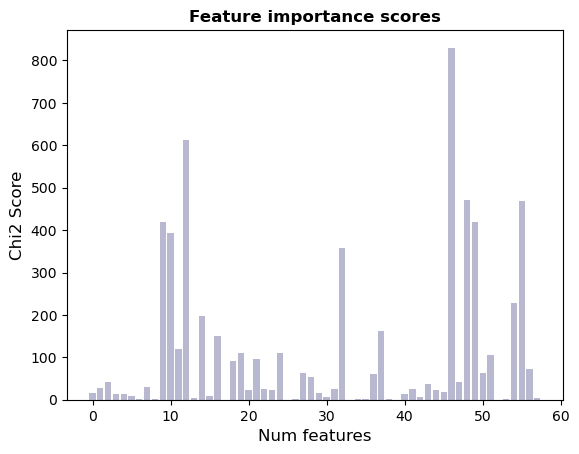

In [61]:
# Evaluation
plt.bar([i for i in range(len(fs_categ.scores_))], fs_categ.scores_, color = '#b8b8d2')
plt.xlabel("Num features", fontsize = 12)
plt.ylabel("Chi2 Score", fontsize = 12)
plt.title('Feature importance scores', fontweight = 'bold', fontsize = 12);

Nous remarquons que certaines features ont bien plus de lien avec la target. Nous allons conserver les **10 plus importantes** et **évaluer** le modèle sur les **données de test**.

Il existe de nombreuses techniques pour sélectionner les caractéristiques sur la base des résultats obtenus. Une bonne approche consiste à évaluer les modèles à l'aide de différentes méthodes de sélection de caractéristiques et de choisir la méthode qui donne le modèle le plus performant.

Pour évaluer notre choix de features, nous utiliserons un modèle de **régression logistique** avec k = 10 caractéristiques puis avec différentes valeurs de k. La régression logistique est un bon modèle pour tester les méthodes de sélection des caractéristiques car elle peut être plus performante si les caractéristiques non pertinentes sont supprimées du modèle.

In [62]:
# Pipeline + entrainement avec sélection des 10 features
fs_categ = SelectKBest(score_func = chi2, k = 10)
model = LogisticRegression(max_iter = 500, random_state=42, class_weight = 'balanced')

pipeline = Pipeline(steps=[('feat_select',fs_categ),
                           ('log_reg', model)])

pipeline.fit(X_train[categ_feat], y_train)

#X_train_fs_categ_10 = pipeline.transform(X_train[categ_feat])
#X_test_fs_categ_10 = pipeline.transform(X_test[categ_feat])

# Evaluation données de test
(biz_fs_chi2_15, beta_fs_chi2_15, rec_fs_chi2_15, prec_fs_chi2_15,
 acc_fs_chi2_15, auc_fs_chi2_15, y_pred_fs_chi2_15) = fct_model.eval_metrics(best_model = pipeline,
                                                                             xtest = X_test[categ_feat],
                                                                             ytest = y_test,
                                                                             beta_value = 2)

Score métier: 64696
Beta score: 0.3228805017359167
Recall: 0.5764847030593881
Precision: 0.11700012174830567
Accuracy: 0.6117786702655241
AUC: 0.5956936789633225


Au lieu de sélectionner arbitrairement k = 15, nous allons tenter de sélectionner le meilleur nombre de features en testant différents paramètres pour k:

In [63]:
# Pipeline
fs_categ = SelectKBest(score_func = chi2, k = 'all')
model = LogisticRegression(max_iter = 500, random_state=42, class_weight = 'balanced')

pipe_fs_chi2 = Pipeline(steps=[('feat_select',fs_categ),
                               ('log_reg', model)])

In [64]:
# Méthode d'évaluation
cv = KFold(n_splits = 5, shuffle = True, random_state = 42)

# Optimisation du modèle
best_model_fs_chi2, best_params_fs_chi2 = fct_model.optimize_and_train_model(pipeline_model = pipe_fs_chi2,
                                                                             xtrain = X_train[categ_feat],
                                                                             ytrain = y_train,
                                                                             params = {'feat_select__k' : [4, 5, 6, 8, 10,
                                                                                                           12, 14, 16, 20],},
                                                                             scoring = make_scorer(fct_model.score_metier,
                                                                                                   greater_is_better=False,),
                                                                             cv = cv)

In [65]:
best_params_fs_chi2

{'feat_select__k': 4}

In [66]:
# Evaluation sur les données de test
(biz_fs_chi2, beta_fs_chi2, rec_fs_chi2, prec_fs_chi2,
 acc_fs_chi2, auc_fs_chi2, y_pred_fs_chi2) = fct_model.eval_metrics(best_model = best_model_fs_chi2,
                                                                    xtest = X_test[categ_feat],
                                                                    ytest = y_test,
                                                                    beta_value = 2)

Score métier: 62768
Beta score: 0.305880095002759
Recall: 0.5098980203959208
Precision: 0.11762535172286545
Accuracy: 0.6491113965626575
AUC: 0.5856658243572523


D'après la grille de recherche, il semblerait qu'il faille garder les 4 variables catégorielles avec le meilleur score.

In [67]:
col_quali_keep = best_model_fs_chi2[:-1].get_feature_names_out().tolist()
col_quali_keep

['NAME_EDUCATION_TYPE_Higher education',
 'YEARS_EMPLOYED_RANGE_3 years or less',
 'YEARS_EMPLOYED_RANGE_More than 8 years',
 'CODE_GENDER']

In [68]:
# Liste des variables catégorielles actualisée
categ_feat = col_quali_keep

In [81]:
# Actualisation de la liste des variables catégorielles et des df
# Nouveaux df
X_train = X_train[num_feat + categ_feat]
X_test = X_test[num_feat + categ_feat]

In [82]:
X_train.shape

(246004, 220)

#### Caractéristiques numériques

De la même manière que pour les variables catégorielles, nous allons utiliser la fonction SelectKBest de Sklearn mais sur nos variables quantitatives en utilisant la méthode Anova (f_classif). Ce test statistique permet de déterminer si les moyennes de plusieurs échantillons de données sont identiques.

In [83]:
# Pipeline
fs_num = SelectKBest(score_func = f_classif, k = 'all')
model = LogisticRegression(max_iter = 500, random_state=42, class_weight = 'balanced')

pipe_fs_anova = Pipeline(steps=[('feat_select',fs_num),
                                ('log_reg', model)])

In [84]:
# Pipeline
preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), num_feat)],
                                 remainder='drop')
fs_num = SelectKBest(score_func = f_classif, k = 'all')
model = LogisticRegression(max_iter = 500, random_state=42, class_weight = 'balanced')

pipe_fs_anova = Pipeline(steps=[('scaler', preprocessor),
                                ('feat_select',fs_num),
                                ('log_reg', model)])

In [85]:
# Méthode d'évaluation
cv = KFold(n_splits = 5, shuffle = True, random_state = 42)

# Optimisation du modèle
best_model_fs_anova, best_params_fs_anova = fct_model.optimize_and_train_model(pipeline_model = pipe_fs_anova,
                                                                               xtrain = X_train[num_feat],
                                                                               ytrain = y_train,
                                                                               params = {'feat_select__k' : [5, 10, 15, 20, 20],},
                                                                               scoring = make_scorer(fct_model.score_metier,
                                                                                                     greater_is_better=False,),
                                                                               cv = cv)

In [86]:
best_params_fs_anova

{'feat_select__k': 20}

In [87]:
# Evaluation sur les données de test
(biz_fs_anova, beta_fs_anova, rec_fs_anova, prec_fs_anova,
 acc_fs_anova, auc_fs_anova, y_pred_fs_anova) = fct_model.eval_metrics(best_model = best_model_fs_anova,
                                                                       xtest = X_test[num_feat],
                                                                       ytest = y_test,
                                                                       beta_value = 2)

Score métier: 55896
Beta score: 0.37333718217026296
Recall: 0.6206758648270346
Precision: 0.14392358696156166
Accuracy: 0.6689484723825628
AUC: 0.6469485518825439


D'après la grille de recherche, il semblerait qu'il faille garder les 20 variables numériques avec le meilleur score:

In [88]:
col_quanti_keep = best_model_fs_anova[:-1].get_feature_names_out().tolist()
col_quanti_keep

['num__FLAG_EMP_PHONE',
 'num__REGION_RATING_CLIENT',
 'num__REGION_RATING_CLIENT_W_CITY',
 'num__REG_CITY_NOT_LIVE_CITY',
 'num__REG_CITY_NOT_WORK_CITY',
 'num__EXT_SOURCE_2',
 'num__FLAG_DOCUMENT_3',
 'num__AGE',
 'num__YEARS_ID_PUBLISH',
 'num__YEARS_LAST_PHONE_CHANGE',
 'num__CREDIT_GOODS_PERC',
 'num__BURO_CREDIT_ACTIVE_Active_SUM',
 'num__PREV_NAME_CONTRACT_STATUS_Approved_MEAN',
 'num__PREV_NAME_CONTRACT_STATUS_Refused_MEAN',
 'num__PREV_CODE_REJECT_REASON_HC_MEAN',
 'num__PREV_CODE_REJECT_REASON_SCOFR_MEAN',
 'num__PREV_CODE_REJECT_REASON_XAP_MEAN',
 'num__PREV_NAME_PRODUCT_TYPE_walk-in_MEAN',
 'num__REFUSEDSK_ID_PREV_COUNT',
 'num__REFUSEDCREDIT_GOODS_PERC_MEAN']

In [89]:
# Liste des variables catégorielles actualisée
num_feat = col_quanti_keep

Les ratios calculés lors de la partie feature engineering étant importants au niveau du métier, nous les rajoutons dans notre modèle:

In [102]:
num_feat = ['CREDIT_DURATION', 'DEBT_RATIO', 'PAYMENT_RATE', 'INCOME_PER_PERSON', 
            'INCOME_CREDIT_PERC', 'CREDIT_GOODS_PERC', 'FLAG_EMP_PHONE','REGION_RATING_CLIENT',
            'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
            'EXT_SOURCE_2', 'FLAG_DOCUMENT_3', 'AGE', 'YEARS_ID_PUBLISH', 'YEARS_LAST_PHONE_CHANGE', 
            'BURO_CREDIT_ACTIVE_Active_SUM', 'PREV_NAME_CONTRACT_STATUS_Approved_MEAN', 
            'PREV_NAME_CONTRACT_STATUS_Refused_MEAN', 'PREV_CODE_REJECT_REASON_HC_MEAN',
            'PREV_CODE_REJECT_REASON_SCOFR_MEAN', 'PREV_CODE_REJECT_REASON_XAP_MEAN', 
            'PREV_NAME_PRODUCT_TYPE_walk-in_MEAN', 'REFUSEDSK_ID_PREV_COUNT', 'REFUSEDCREDIT_GOODS_PERC_MEAN']

In [103]:
# Actualisation de la liste des variables catégorielles et des df
# Nouveaux df
X_train = X_train[num_feat + categ_feat]
X_test = X_test[num_feat + categ_feat]

In [104]:
X_train.shape

(246004, 29)

## Traitement des données déséquilibrées <a class="anchor" id="imbalanced"></a>

Lors de l'analyse exploratoire, nous avons remarqué que les données étaient très **déséquilibrées** entre les défaillants et non défaillants. Les non défaillants sont largement sur représentés (> 91%).

La plupart des modèles de Machine Learning vont **ignorer la classe minoritaire** et donc avoir des **performances médiocres** dans cette classe alors qu'en général c'est la performance de la classe minoritaire qui est la plus importante.

Une des approches pour traiter les ensembles de données déséquilibrés consiste à suréchantillonner la classe minoritaire. La méthode la plus simple est de **dupliquer les exemples de la classe minoritaire** même si aucune information n'est ajoutée au modèle.

Il est également possible de **pondérer les classes** c'est à dire ajuster la fonction de coût du modèle de manière à ce qu'une mauvaise classification d'une observation de la classe minoritaire soit plus lourdement pénalisée qu'une mauvaise classification d'une observation de la classe majoritaire. Cette approcge contribue à améliorer la précision du modèle en rééquilibrant la distribution des classes. Comme aucun nouveau point de données n'est créé, la méthode doit ête utilisée conjointement avec d'autres méthodes comme le suréchantillonnage par exemple.

Au lieu de cela, de nouveaux **exemples peuvent être synthétisés à partir des exemples existants**. Il s'agit d'un type d'augmentation de données pour la classe minoritaire appelé **SMOTE** pour (Synthetic Minority Oversampling Technique ou Technique de suréchantillonnage synthétique des minorités).

Un **exemple aléatoire de la classe minoritaire** est choisi et les k plus proches voisins sont trouvés (avec k = 5 en général). **Un voisin est choisi au hasard** et un segment est tracé entre les 2 points.
 
Il est recommandé d'utiliser d'abord un **sous-échantillonnage aléatoire** pour réduire le nombre d'exemples dans la classe minoritaire puis d'utiliser **SMOTE** pour suréchantillonner la classe minoritaire afin d'équilibrer la distribution des classes. C'est une approche efficace car les nouveaux exemples synthétiques de la classe minoritaire sont plausibles (proches dans l'espace des caractéristiques des exemples existants de la classe minoritaire).

L'inconvénient général serait que les exemples synthétiques sont créés sans tenir compte de la classe majoritaire.

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

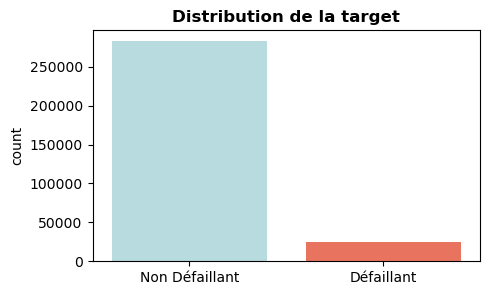

In [105]:
# Distribution de la target
plt.figure(figsize=(5,3))
sns.countplot(x = 'TARGET', data = df, palette=['powderblue', 'tomato'])
plt.title('Distribution de la target', fontweight='bold', fontsize = 12)
x = [0, 1]
plt.xticks(x, ['Non Défaillant', 'Défaillant'])
plt.xlabel('');

In [106]:
Counter(df['TARGET'])

Counter({1: 24825, 0: 282680})

## Pipeline, optimisation et entrainement des modèles <a class="anchor" id="pipe"></a>

Nous allons dans un premier temps créer une **pipeline** pour chacun de nos modèles. Cette pipeline va nous permettre d'affecter des étapes de preprocessing à nos données, c'est à dire des transformations comme le **traitement des données déséquilibrées**, la **standardisation**, et de choisir le **type de modèle**.

Cette pipeline sera ensuite intégrée dans une fonction d'optimisation et d'entrainement qui va utiliser la **validation croisée** pour tester la robustesse du modèle prédictif en répétant la procédure de split. Elle donnera plusieurs erreurs d'apprentissage et de test et donc une **estimation de la variabilité de la performance de généralisation du modèle**. 

Nous allons comparer l'erreur de validation avec l'erreur d'entrainement. On va créer un **validation set** qui va nous permettre d'optimiser les réglages du modèle qui donne les meilleures performances tout en gardant de côté les données du test set pour évaluer le modèle sur des données qu'il n'aura jamais vues.

Le réglage des hyperparamètres s'effectuera soit à l'aide du  **GridSearchCV** qui va tester toutes les combinaisons possibles d'hyperparamètres afin de trouver celles qui vont minimiser le plus l'erreur (méthode exhaustive très **coûteuse en termes de puissance de calcul et de temps**), soit du **RandomizedSearchCV** qui va sélectionner des combinaisaons aléatoires d'hyperparamètres. Cette méthode est **un peu moins précise mais beaucoup plus rapide**. Elle sera utilisée pour les modèles plus complexes.

Enfin, pour évaluer la **performance réelle de nos modèles**, nous calculerons les metrics choisis sur les données de test.

## Choix des scores <a class="anchor" id="scores"></a>

Si l'on se réfère au fichier de description des colonnes:
- **1** => clients a des difficultés de paiement, il a eu un retard de paiement de plus de X jours sur au moins une des Y premières échéances du prêt dans notre échantillon (**défaillant**)
- **0** => tous les autres cas (**non défaillant**)

Sur une matrice de confusion, les défaillants représentent la classe positive (Y=1) et les non défaillants la classe négative (Y=0).

Comme il serait extrêment coûteux pour la banque d'accorder un crédit à un client défaillant qui ne le rembourserait pas ou en partie, il nous faut **minimiser le nombre de faux négatifs** c'est à dire un client prédit non défaillant alors qu'il est défaillant.

Il faut également tâcher de **minimiser les faux positifs** c'est à dire prédire qu'un client est défaillant alors qu'il ne l'est pas (risque de perte de clients, de manque à gagner).

Cependant, un faux positif n'a pas le même coût qu'un faux négatif. Ce dernier est beaucoup plus coûteux pour la banque. **Nous accorderons donc plus de poids aux faux négatifs** (fonction coût métier) et supposerons qu'ils sont 10 fois plus coûteux que les faux positifs (eux même 5 fois plus coûteux que les vrais positifs et vrais négatifs). Les modèles seront évalués sur ce score métier.

Le **Rappel (Recall)** qui mesure le taux de vrais positifs est à favoriser au détriment de la précision qui est la capacité du classificateur à ne pas étiqueter comme positif un échantillon qui est négatif.

Pour faire cela, nous allons nous baser sur le **F-beta score** qui est la moyenne harmonique pondérée de la précision et du rappel. Le paramètre bêta détermine le poids du rappel dans le score. Lorsqu'il est suppérieur à un, il favorise le rappel.

Nous mettrons également l'**accuracy** et l'**AUC** comme éléments de comparaison. Le **temps d'entrainement** sera également tracké.

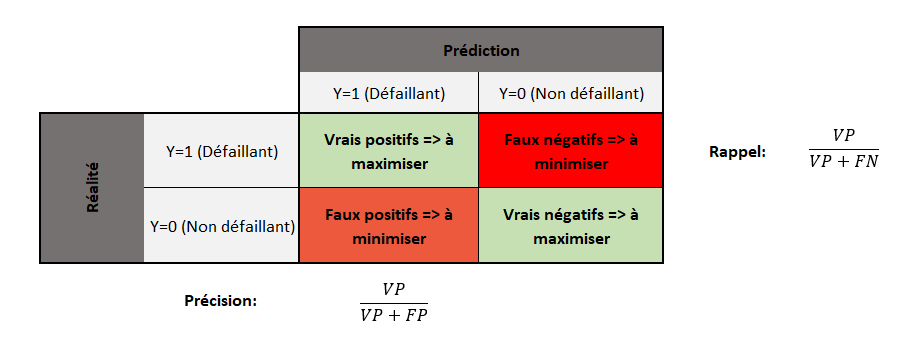

## Modélisations <a class="anchor" id="model"></a>

Nous cherchons à classer les demandes en **crédit accordé ou refusé**. Il s'agit donc d'un modèle de **classification**.modèle

ne pas avoir de rouge

si on max le rappel on n'a que des vp donc pas de fn => ce qu'on veut (num = denominateur)

formule rappel + facteur fn à min (+10*fn + 2*fp)


predict proba rand 0 et 1


precision entre 0.6 et 1
ypred proba > seuil
boucle sur chacun des seuils (predict_proba)





SEPARER PARTIE ENTRAINEMENT ET D'EVALUATION
predict proba puis jouer avec le seuil => faire boucle entre 0.3 et 0.8 + courbe précision recall

In [ ]:
def score_metier(ytest, y_pred):
    # Matrice de confusion transformée en array avec affectation aux bonnes catégories
    (vn, fp, fn, vp) = confusion_matrix(ytest, y_pred).ravel()
    
    # Rappel avec action fp => à minimiser
    score_metier = 10*fn + 2*fp
    
    return score_metier

In [ ]:
def eval_metrics(best_model, xtest, ytest, beta_value):
    
    y_pred = best_model.predict(xtest)
    
    score_biz = score_metier(ytest, y_pred)
    betascore = fbeta_score(ytest, y_pred, beta = beta_value)
    recall = recall_score(ytest, y_pred)
    precision = precision_score(ytest, y_pred)
    accuracy = accuracy_score(ytest, y_pred)
    auc = roc_auc_score(ytest, y_pred)
    
    return score_biz, betascore, recall, precision, accuracy, auc, y_pred

In [ ]:
def matrice_confusion(ytest, ypred, model_name):
    plt.figure(figsize=(5, 5))
    cm = confusion_matrix(ytest, ypred)
    sns.heatmap(cm,
                xticklabels=['Y=0 (Non défaillant)', 'Y=1 (Défaillant)'],
                yticklabels=['Y=0 (Non défaillant)', 'Y=1 (Défaillant)'],
                annot=True,
                fmt='d', 
                linewidth=.5, 
                cmap = sns.cubehelix_palette(as_cmap=True), cbar=False)
    plt.title(f'Matrice de confusion: {model_name}')
    plt.ylabel('Réalité')
    plt.xlabel('Prédiction')
    plt.show()

In [ ]:
def pipeline_model(model, numeric_features, numeric_transformer):

    # Transformations à effectuer sur nos variables
    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),])

    # Définition de la pipeline du modèle: étapes de preprocessing + classifier
    pipeline_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)])
    
    return pipeline_model

In [ ]:
def pipeline_model_balanced(model, numeric_features, numeric_transformer,
                            oversampling_strategy, undersampling_strategy):

    # Sur échantillonnage de la classe minoritaire (10% de la classe majoritaire ~= 23000)
    oversampler = SMOTE(sampling_strategy = oversampling_strategy, random_state = 42)

    # Sous échantillonnage pour réduire la classe majoritaire (50% de plus que la classe minoritaire ~= 46000
    undersampler = RandomUnderSampler(sampling_strategy = undersampling_strategy, random_state = 42)
    
    # Transformations à effectuer sur nos variables
    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),])
    
    # Définition de la pipeline du modèle: étapes de preprocessing + classifier
    pipeline_model_balanced = pipe(steps=[
        ('over', oversampler),
        ('under', undersampler),
        ('preprocessor', preprocessor),
        ('classifier', model)])
    
    return pipeline_model_balanced

In [ ]:
def optimize_and_train_model(pipeline_model, xtrain, ytrain, params, scoring, cv):
    
    _ = pipeline_model.fit(xtrain, ytrain)


    # Réglage automatique des meilleurs hyperparamètres avec GridSearchCV
    #inner_cv = KFold(n_splits = 5, shuffle = True, random_state = 42)
    model_grid_cv = GridSearchCV(pipeline_model, 
                                 param_grid = params, 
                                 cv = cv, 
                                 scoring = scoring,
                                 refit=True)

    model_grid_cv.fit(xtrain, ytrain)
    
    best_model = model_grid_cv.best_estimator_
    best_params = model_grid_cv.best_params_

    return best_model, best_params

In [ ]:
def optimize_and_train_model_RSCV(pipeline_model, xtrain, ytrain, params, scoring):
    
    _ = pipeline_model.fit(xtrain, ytrain)


    # Réglage automatique des meilleurs hyperparamètres avec GridSearchCV
    inner_cv = KFold(n_splits = 5, shuffle = True, random_state = 42)
    model_grid_cv = RandomizedSearchCV(pipeline_model, 
                                       param_distributions = params, 
                                       cv = inner_cv, 
                                       scoring = scoring,
                                       refit=True)

    model_grid_cv.fit(xtrain, ytrain)
    
    best_model = model_grid_cv.best_estimator_
    best_params = model_grid_cv.best_params_

    return best_model, best_params

In [ ]:
def eval_model(model_name, best_model, best_params, xtest, ytest, categ_features):
    # Evaluation du modèle sur les données de test
    (score_biz, recall, precision, accuracy, auc, y_pred) = eval_metrics(best_model = best_model,
                                                                         xtest = xtest,
                                                                         ytest = ytest)
    
    matrice_confusion(ytest, y_pred, model_name)
    
    # Récap
    dic_df_recap = {'Modèle':[model_name],
                    'Variables':[categ_features],
                    'Best_Params':[best_params],
                    'Score_metier':[score_biz],
                    'Recall':[recall], 
                    'Precision':[precision], 
                    'Accuracy':[accuracy], 
                    'AUC':[auc],}
                    #"Train_Time": [duration],
    df_recap = pd.DataFrame(data = dic_df_recap)
    display(df_recap)
    
    return best_model, df_recap

In [ ]:
def best_model(model_name, model,
               xtrain, numeric_features, numeric_transformer, 
               ytrain, params, scoring, xtest, ytest, 
               oversampling_strategy = 0.1, undersampling_strategy = 0.5, balanced = False, Randomized = False):
    
    if balanced == False:
        start = time.time()
        model = pipeline_model(model = model,
                               numeric_features = numeric_features,
                               numeric_transformer = numeric_transformer)

        if RandomizedSearchCV == False:
            # Optimisation via cross validation & GridSearch
            best_model, best_params = optimize_and_train_model(pipeline_model = model,
                                                               xtrain = xtrain[numeric_features],
                                                               ytrain = ytrain,
                                                               params = params,
                                                               scoring = scoring)
            
        else:
            # Optimisation via cross validation & RandomizedSearch
            best_model, best_params = optimize_and_train_model_RSCV(pipeline_model = model,
                                                                    xtrain = xtrain[numeric_features],
                                                                    ytrain = ytrain,
                                                                    params = params,
                                                                    scoring = scoring)


        duration = time.time() - start
        
    else:
        
        start = time.time()
        model = pipeline_model_balanced(model, numeric_features, numeric_transformer,
                                        oversampling_strategy = oversampling_strategy, 
                                        undersampling_strategy = undersampling_strategy)

        if RandomizedSearchCV == False:
        # Optimisation via cross validation & GridSearch
            best_model, best_params = optimize_and_train_model(pipeline_model = model,
                                                               xtrain = xtrain[numeric_features],
                                                               ytrain = ytrain,
                                                               params = params,
                                                               scoring = scoring)
        
        else:
            best_model, best_params = optimize_and_train_model_RSCV(pipeline_model = model,
                                                                    xtrain = xtrain[numeric_features],
                                                                    ytrain = ytrain,
                                                                    params = params,
                                                                    scoring = scoring)    


        duration = time.time() - start

    
    # Evaluation du modèle sur les données de test
    (score_biz, recall, precision, accuracy, auc, y_pred) = eval_metrics(
        best_model = best_model,
        xtest = xtest[numeric_features],
        ytest = ytest)
    

    matrice_confusion(ytest, y_pred, model_name)
    
    # Récap
    dic_df_recap = {'Modèle':[model_name],
                    'Features':[numeric_features],
                    'Best_Params':[best_params],
                    'Score_metier':[score_biz],
                    'Recall':[recall], 
                    'Precision':[precision], 
                    'Accuracy':[accuracy], 
                    'AUC':[auc], 
                    "Train_Time": [duration],}
    df_recap = pd.DataFrame(data = dic_df_recap)
    display(df_recap)
    
    return best_model, df_recap

### Modèle Baseline: Dummy classifier <a class="anchor" id="dummy"></a>

Ce classificateur fait des prédictions en utilisant des règles simples. Il est utile comme **base de référence simple** à comparer avec d'autres classificateurs et ne sera pas optimisé. Il ignore les variables en entrée et par conséquent, n'utilise aucune information provenant des features. Il n'y a donc **pas besoin de transformer au préalable nos features**.

In [129]:
def score_metier(ytest, y_pred):
    # Matrice de confusion transformée en array avec affectation aux bonnes catégories
    (vn, fp, fn, vp) = confusion_matrix(ytest, y_pred).ravel()
    
    # Rappel avec action fp => à minimiser
    score_metier = 10*fn + 2*fp
    
    return score_metier

In [130]:
def pipeline_model(model, numeric_features, numeric_transformer):

    # Transformations à effectuer sur nos variables
    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),])

    # Définition de la pipeline du modèle: étapes de preprocessing + classifier
    pipeline_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)])
    
    return pipeline_model

In [131]:
def optimize_and_train_model(pipeline_model, xtrain, ytrain, params, scoring, cv):
    
    _ = pipeline_model.fit(xtrain, ytrain)


    # Réglage automatique des meilleurs hyperparamètres avec GridSearchCV
    #inner_cv = KFold(n_splits = 5, shuffle = True, random_state = 42)
    model_grid_cv = GridSearchCV(pipeline_model, 
                                 param_grid = params, 
                                 cv = cv, 
                                 scoring = scoring,
                                 refit=True)

    model_grid_cv.fit(xtrain, ytrain)
    
    best_model = model_grid_cv.best_estimator_
    best_params = model_grid_cv.best_params_

    return best_model, best_params

In [132]:
def optimize_and_train_model_RSCV(pipeline_model, xtrain, ytrain, params, scoring, cv):
    
    _ = pipeline_model.fit(xtrain, ytrain)


    # Réglage automatique des meilleurs hyperparamètres avec GridSearchCV
    #inner_cv = KFold(n_splits = 5, shuffle = True, random_state = 42)
    model_grid_cv = RandomizedSearchCV(pipeline_model, 
                                       param_distributions = params, 
                                       cv = cv, 
                                       scoring = scoring,
                                       refit=True)

    model_grid_cv.fit(xtrain, ytrain)
    
    best_model = model_grid_cv.best_estimator_
    best_params = model_grid_cv.best_params_

    return best_model, best_params

In [137]:
def optimize_and_train_model_RSCV(pipeline_model, xtrain, ytrain, params, scoring, cv):
    
    _ = pipeline_model.fit(xtrain, ytrain)


    # Réglage automatique des meilleurs hyperparamètres avec GridSearchCV
    inner_cv = KFold(n_splits = 5, shuffle = True, random_state = 42)
    model_grid_cv = RandomizedSearchCV(pipeline_model, 
                                       param_distributions = params, 
                                       cv = inner_cv, 
                                       scoring = scoring,
                                       refit=True)

    model_grid_cv.fit(xtrain, ytrain)
    
    best_model = model_grid_cv.best_estimator_
    best_params = model_grid_cv.best_params_

    return best_model, best_params

In [167]:
def best_model(model_name, model, cv,
               xtrain, numeric_features, numeric_transformer, 
               ytrain, params, scoring, xtest, ytest, 
               oversampling_strategy = 0.1, undersampling_strategy = 0.5, balanced = False, Randomized = False):
    
    if balanced == False:
        start = time.time()
        model = pipeline_model(model = model,
                               numeric_features = numeric_features,
                               numeric_transformer = numeric_transformer)

        if RandomizedSearchCV == False:
            # Optimisation via cross validation & GridSearch
            best_model, best_params = optimize_and_train_model(pipeline_model = model,
                                                               xtrain = xtrain[numeric_features],
                                                               ytrain = ytrain,
                                                               params = params,
                                                               scoring = scoring,
                                                               cv = cv)
            
        else:
            # Optimisation via cross validation & RandomizedSearch
            best_model, best_params = optimize_and_train_model_RSCV(pipeline_model = model,
                                                                    xtrain = xtrain[numeric_features],
                                                                    ytrain = ytrain,
                                                                    params = params,
                                                                    scoring = scoring,
                                                                    cv = cv)


        duration = time.time() - start
        
    else:
        
        start = time.time()
        model = pipeline_model_balanced(model, numeric_features, numeric_transformer,
                                        oversampling_strategy = oversampling_strategy, 
                                        undersampling_strategy = undersampling_strategy)

        if RandomizedSearchCV == False:
        # Optimisation via cross validation & GridSearch
            best_model, best_params = optimize_and_train_model(pipeline_model = model,
                                                               xtrain = xtrain[numeric_features],
                                                               ytrain = ytrain,
                                                               params = params,
                                                               scoring = scoring,
                                                               cv = cv)
        
        else:
            best_model, best_params = optimize_and_train_model_RSCV(pipeline_model = model,
                                                                    xtrain = xtrain[numeric_features],
                                                                    ytrain = ytrain,
                                                                    params = params,
                                                                    scoring = scoring,
                                                                    cv = cv)    


        duration = time.time() - start
    
    return best_model, best_params, model_name, duration

In [168]:
dummy, dummy_params, dummy_name, dummy_duration = best_model(model_name = 'Baseline - Dummy classifier',
                                                  model = DummyClassifier(random_state = 42), 
                                                  cv = KFold(n_splits = 5, shuffle = True, random_state = 42),
                                                  xtrain = X_train,
                                                  numeric_features = num_feat,
                                                  numeric_transformer = StandardScaler(),
                                                  ytrain = y_train,
                                                  params = {'classifier__strategy' : ['most_frequent', 'prior',
                                                                                      'stratified', 'uniform'],},
                                                 scoring = make_scorer(score_metier, greater_is_better=False),
                                                 xtest = X_test,
                                                 ytest = y_test,
                                                 oversampling_strategy = 0.1,
                                                 undersampling_strategy = 0.5, 
                                                 balanced = False,
                                                 Randomized = False)

C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [170]:
dummy_params

{'classifier__strategy': 'most_frequent'}

In [171]:
def eval_metrics(best_model, xtest, ytest, beta_value):
    
    y_pred = best_model.predict(xtest)
    
    score_biz = score_metier(ytest, y_pred)
    betascore = fbeta_score(ytest, y_pred, beta = beta_value)
    recall = recall_score(ytest, y_pred)
    precision = precision_score(ytest, y_pred, zero_division=0)
    accuracy = accuracy_score(ytest, y_pred)
    auc = roc_auc_score(ytest, y_pred)
    
    print(f'Score métier: {score_biz}')
    print(f'Beta score: {betascore}')
    print(f'Recall: {recall}')
    print(f'Precision: {precision}')
    print(f'Accuracy: {accuracy}')
    print(f'AUC: {auc}')
    
    return score_biz, betascore, recall, precision, accuracy, auc, y_pred

In [172]:
# Evaluation sur les données de test
(biz_dummy, beta_dummy, rec_dummy, prec_dummy,
 acc_dummy, auc_dummy, y_pred_dummy) = fct_model.eval_metrics(best_model = dummy,
                                                              xtest = X_test,
                                                              ytest = y_test,
                                                              beta_value = 2)

Score métier: 50010
Beta score: 0.0
Recall: 0.0
Precision: 0.0
Accuracy: 0.9186842490366011
AUC: 0.5


In [173]:
def matrice_confusion(ytest, ypred, model_name):
    plt.figure(figsize=(5, 5))
    cm = confusion_matrix(ytest, ypred)
    sns.heatmap(cm,
                xticklabels=['Y=0 (Non défaillant)', 'Y=1 (Défaillant)'],
                yticklabels=['Y=0 (Non défaillant)', 'Y=1 (Défaillant)'],
                annot=True,
                fmt='d', 
                linewidth=.5, 
                cmap = sns.cubehelix_palette(as_cmap=True), cbar=False)
    plt.title(f'Matrice de confusion: {model_name}')
    plt.ylabel('Réalité')
    plt.xlabel('Prédiction')
    plt.show()

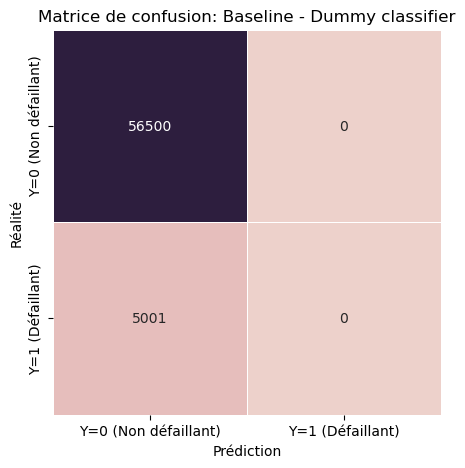

In [174]:
matrice_confusion(ytest = y_test,
                  ypred = y_pred_dummy,
                  model_name = dummy_name)

**Démarche MLOps**

In [ ]:
!mlflow --version

In [ ]:
# Création du tracking cad où MLFlow sauvegarde les runs
mlflow.set_tracking_uri("file:///Users/milie/01_PYTHON/4. OPEN_CLASSROOMS/07_PROJET_7/mlruns")

# Création d'un experiment
experiment_id = mlflow.create_experiment("Training binary classifier")


with mlflow.start_run(experiment_id = experiment_id):
    start_Dummy = time.time()
    model = DummyClassifier()

    # Sélection des hyperparamètres
    params = {'strategy' : ['most_frequent', 'prior', 'stratified', 'uniform'],}
    scoring = make_scorer(recall_score)

    best_model_Dummy, best_params_Dummy = optimize_and_train_model(pipeline_model = model,
                                                                    xtrain = X_train,
                                                                    ytrain = y_train,
                                                                    params = params,
                                                                    scoring = scoring)


    duration_Dummy = time.time() - start_Dummy
    
    # Evaluation du modèle
    (recall, precision, accuracy, auc) = eval_metrics(best_model = best_model_Dummy,
                                                      xtest = X_test,
                                                      ytest = y_test)
    
    print(f"DummyClassifier Model with param strategy = {best_params_Dummy['strategy']}")
    print()
    print(f"Recall: {recall:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"AUC: {auc:.2f}")
    print(f"Train time: {duration_Dummy:.2f}")
    
    # log des paramètres et scores à chaque fois que le modèle est lancé
    mlflow.log_param("strategy", best_params_Dummy['strategy'])
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("auc", auc)
    mlflow.log_metric("Tps_entrainement", duration_Dummy)
    
    mlflow.sklearn.log_model(best_model_Dummy, "dummyclassifier")

### Régression logistique <a class="anchor" id="reglog"></a>

La régression logistique est un modèle statistique qui permet d'étudier la **relation entre une variable binaire** dite variable dépendante / cible et **une ou plusieurs variables indépendantes**.

Il s'agit d'un **modèle linéaire** généralisé utilisant une fonction logistique comme fonction de lien. Il permet également de prédire la **probabilité qu'un événement arrive ou non** à partir de l'optimisation des coefficients de régression. Lorsque la valeur est > à un seuil, l'événement est susceptible de se produire alors que lorsque cette valeur est < au même seuil, il ne l'est pas.

Nous allons tenter d'optimiser ce modèle en jouant sur les **features**, le traitement du **déséquilibre des classes** et les **hyperparamètres** via **cross validation** et **GridSearch**:
- penalty: pénalité
- solver: algorithme à utiliser pour l'optimisation
- C : force de la pénalité (valeurs plus petites => régularisation plus forte)

#### Modélisation sur données non équilibrées

In [175]:
reglog, reglog_params, reglog_name, reglog_duration = best_model(model_name = 'Régression Logistique',
                                                     model = LogisticRegression(max_iter = 200, random_state=42),
                                                     cv = KFold(n_splits = 5, shuffle = True, random_state = 42),
                                                     xtrain = X_train,
                                                     numeric_features = num_feat,
                                                     numeric_transformer = StandardScaler(),
                                                     ytrain = y_train,
                                                     params = {"classifier__penalty": ['l2', 'l1'],
                                                               "classifier__solver": ['lbfgs', 'saga'],
                                                               "classifier__C": [100, 10, 1.0, 0.1, 0.01],},
                                                     scoring = make_scorer(score_metier, greater_is_better=False),
                                                     xtest = X_test,
                                                     ytest = y_test,
                                                     oversampling_strategy = 0.1,
                                                     undersampling_strategy = 0.5,
                                                     balanced = False,
                                                     Randomized = False)

C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
  

In [176]:
reglog_params

{'classifier__solver': 'lbfgs',
 'classifier__penalty': 'l2',
 'classifier__C': 1.0}

In [177]:
# Evaluation sur les données de test
(biz_reglog, beta_reglog, rec_reglog, prec_reglog,
 acc_reglog, auc_reglog, y_pred_reglog) = fct_model.eval_metrics(best_model = reglog,
                                                                 xtest = X_test,
                                                                 ytest = y_test,
                                                                 beta_value = 2)

Score métier: 49812
Beta score: 0.005985335926978901
Recall: 0.004799040191961607
Precision: 0.5333333333333333
Accuracy: 0.9187330287312402
AUC: 0.5022136793880161


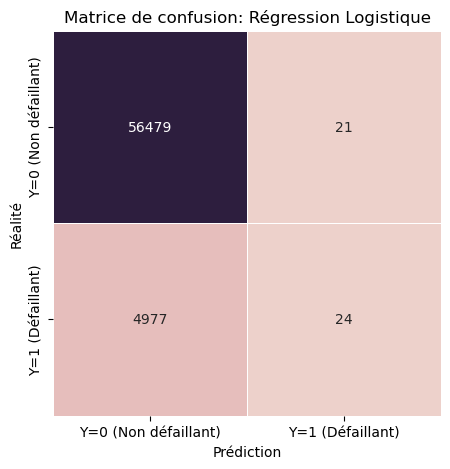

In [178]:
matrice_confusion(ytest = y_test,
                  ypred = y_pred_reglog,
                  model_name = reglog_name)

#### Modélisation sur données rééquilibrées: pondération des classes 

Chaque algorithme de classification SKlearn possède un paramètre appelé **class_weight** qui permet de gérer le déséquilibre des classes. Nous allons tester via la GridSearch avec le paramètre **'balanced'** (ajustement automatique des poids de manière inversement proportionnelle aux fréquences des classes dans les données d'entrée) et un **choix arbitraire de poids** (3 fois plus de poids pour les défaillants):

In [183]:
reglog_cw, reglog_params_cw, reglog_name_cw, reglog_duration_cw = best_model(model_name = 'Régression Logistique',
                                                     model = LogisticRegression(max_iter = 200, random_state=42, class_weight='balanced'),
                                                     cv = KFold(n_splits = 5, shuffle = True, random_state = 42),
                                                     xtrain = X_train,
                                                     numeric_features = num_feat,
                                                     numeric_transformer = StandardScaler(),
                                                     ytrain = y_train,
                                                     params = {"classifier__penalty": ['l2', 'l1'],
                                                               "classifier__solver": ['lbfgs', 'saga'],
                                                               "classifier__C": [100, 10, 1.0, 0.1, 0.01],},
                                                     scoring = make_scorer(score_metier, greater_is_better=False),
                                                     xtest = X_test,
                                                     ytest = y_test,
                                                     oversampling_strategy = 0.1,
                                                     undersampling_strategy = 0.5,
                                                     balanced = False,
                                                     Randomized = True)

C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    

In [184]:
reglog_params_cw

{'classifier__solver': 'saga',
 'classifier__penalty': 'l2',
 'classifier__C': 0.01}

In [188]:
# Evaluation sur les données de test
(biz_reglog_cw, beta_reglog_cw, rec_reglog_cw, prec_reglog_cw,
 acc_reglog_cw, auc_reglog_cw, y_pred_reglog_cw) = fct_model.eval_metrics(best_model = reglog_cw,
                                                                          xtest = X_test,
                                                                          ytest = y_test,
                                                                          beta_value = 2)

Score métier: 55042
Beta score: 0.3808410088248059
Recall: 0.6316736652669466
Precision: 0.1471355379599441
Accuracy: 0.6723142713126616
AUC: 0.6537925848458627


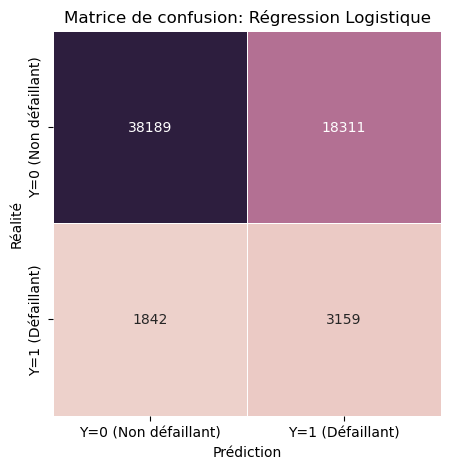

In [189]:
matrice_confusion(ytest = y_test,
                  ypred = y_pred_reglog_cw,
                  model_name = reglog_name_cw)

#### Modélisation sur données rééquilibrées: sous échantillonage + SMOTE

In [191]:
def pipeline_model_balanced(model, numeric_features, numeric_transformer,
                            oversampling_strategy, undersampling_strategy):

    # Sur échantillonnage de la classe minoritaire (10% de la classe majoritaire ~= 23000)
    oversampler = SMOTE(sampling_strategy = oversampling_strategy, random_state = 42)

    # Sous échantillonnage pour réduire la classe majoritaire (50% de plus que la classe minoritaire ~= 46000
    undersampler = RandomUnderSampler(sampling_strategy = undersampling_strategy, random_state = 42)
    
    # Transformations à effectuer sur nos variables
    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),])
    
    # Définition de la pipeline du modèle: étapes de preprocessing + classifier
    pipeline_model_balanced = pipe(steps=[
        ('over', oversampler),
        ('under', undersampler),
        ('preprocessor', preprocessor),
        ('classifier', model)])
    
    return pipeline_model_balanced

Avec sur-échantillonnage de la classe minoritaire (10% de la classe majoritaire ~= 23000) et sous échantillonnage pour réduire la classe majoritaire (50% de plus que la classe minoritaire ~= 46000):

In [199]:
(reglog_smote1050, reglog_smote_params1050,
 reglog_smote_name1050, reglog_smote_duration1050) = best_model(model_name = 'Régression Logistique - SMOTE 10/50',
                                                                model = LogisticRegression(max_iter = 200, 
                                                                                           random_state=42,),
                                                                cv = KFold(n_splits = 5, shuffle = True, random_state = 42),
                                                                xtrain = X_train,
                                                                numeric_features = num_feat,
                                                                numeric_transformer = StandardScaler(),
                                                                ytrain = y_train,
                                                                params = {"classifier__penalty": ['l2', 'l1'],
                                                                          "classifier__solver": ['lbfgs', 'saga'],
                                                                          "classifier__C": [100, 10, 1.0, 0.1, 0.01],},
                                                                scoring = make_scorer(score_metier, 
                                                                                      greater_is_better=False),
                                                                xtest = X_test,
                                                                ytest = y_test,
                                                                oversampling_strategy = 0.1,
                                                                undersampling_strategy = 0.5,
                                                                balanced = True,
                                                                Randomized = True)

C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit


In [200]:
reglog_smote_params1050

{'classifier__solver': 'saga',
 'classifier__penalty': 'l1',
 'classifier__C': 0.01}

In [201]:
# Evaluation sur les données de test
(biz_reglog_SMOTE1050, beta_reglog_SMOTE1050, rec_reglog_SMOTE1050, prec_reglog_SMOTE1050,
 acc_reglog_SMOTE1050, auc_reglog_SMOTE1050, y_pred_reglog_SMOTE1050) = fct_model.eval_metrics(best_model = reglog_smote1050,
                                                                                               xtest = X_test,
                                                                                               ytest = y_test,
                                                                                               beta_value = 2)

Score métier: 45736
Beta score: 0.2839378620715103
Recall: 0.3077384523095381
Precision: 0.21685219106664788
Accuracy: 0.8533357181184046
AUC: 0.6046833854468044


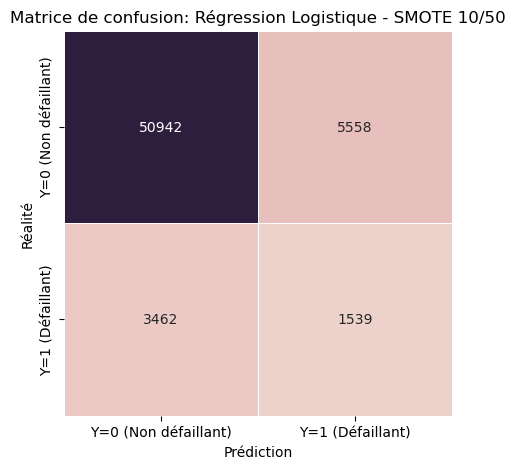

In [202]:
matrice_confusion(ytest = y_test,
                  ypred = y_pred_reglog_SMOTE1050,
                  model_name = reglog_smote_name1050)

Avec sur-échantillonnage de la classe minoritaire (20% de la classe majoritaire) et sous échantillonnage pour réduire la classe majoritaire (30% de plus que la classe minoritaire):

In [203]:
(reglog_smote2030, reglog_smote_params2030,
 reglog_smote_name2030, reglog_smote_duration2030) = best_model(model_name = 'Régression Logistique - SMOTE 20/30',
                                                                model = LogisticRegression(max_iter = 200, 
                                                                                           random_state=42,),
                                                               cv = KFold(n_splits = 5, shuffle = True, random_state = 42),
                                                               xtrain = X_train,
                                                               numeric_features = num_feat,
                                                               numeric_transformer = StandardScaler(),
                                                               ytrain = y_train,
                                                               params = {"classifier__penalty": ['l2', 'l1'],
                                                                         "classifier__solver": ['lbfgs', 'saga'],
                                                                         "classifier__C": [100, 10, 1.0, 0.1, 0.01],},
                                                               scoring = make_scorer(score_metier, greater_is_better=False),
                                                               xtest = X_test,
                                                               ytest = y_test,
                                                               oversampling_strategy = 0.2,
                                                               undersampling_strategy = 0.3,
                                                               balanced = True,
                                                               Randomized = True)

C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit


In [204]:
reglog_smote_params2030

{'classifier__solver': 'lbfgs',
 'classifier__penalty': 'l2',
 'classifier__C': 0.1}

In [205]:
# Evaluation sur les données de test
(biz_reglog_SMOTE2030, beta_reglog_SMOTE2030, rec_reglog_SMOTE2030, prec_reglog_SMOTE2030,
 acc_reglog_SMOTE2030, auc_reglog_SMOTE2030, y_pred_reglog_SMOTE2030) = fct_model.eval_metrics(best_model = reglog_smote2030,
                                                                                               xtest = X_test,
                                                                                               ytest = y_test,
                                                                                               beta_value = 2)

Score métier: 46854
Beta score: 0.16339441535776617
Recall: 0.14977004599080185
Precision: 0.25685871056241427
Accuracy: 0.8956277133705143
AUC: 0.5557080318449584


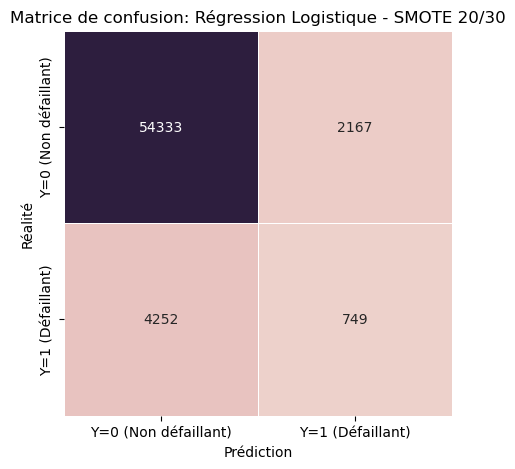

In [206]:
matrice_confusion(ytest = y_test,
                  ypred = y_pred_reglog_SMOTE2030,
                  model_name = reglog_smote_name2030)

Avec sur-échantillonnage de la classe minoritaire (10% de la classe majoritaire) et sous échantillonnage pour réduire la classe majoritaire (60% de plus que la classe minoritaire):

In [207]:
(reglog_smote1060, reglog_smote_params1060,
 reglog_smote_name1060, reglog_smote_duration1060) = best_model(model_name = 'Régression Logistique - SMOTE 10/60',
                                                                model = LogisticRegression(max_iter = 200, 
                                                                                           random_state=42,),
                                                                cv = KFold(n_splits = 5, shuffle = True, random_state = 42),
                                                                xtrain = X_train,
                                                                numeric_features = num_feat,
                                                                numeric_transformer = StandardScaler(),
                                                                ytrain = y_train,
                                                                params = {"classifier__penalty": ['l2', 'l1'],
                                                                          "classifier__solver": ['lbfgs', 'saga'],
                                                                          "classifier__C": [100, 10, 1.0, 0.1, 0.01],},
                                                                scoring = make_scorer(score_metier, greater_is_better=False),
                                                                xtest = X_test,
                                                                ytest = y_test,
                                                                oversampling_strategy = 0.1,
                                                                undersampling_strategy = 0.6,
                                                                balanced = True,
                                                                Randomized = True)

C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit


In [208]:
reglog_smote_params1060

{'classifier__solver': 'saga',
 'classifier__penalty': 'l1',
 'classifier__C': 0.01}

In [209]:
# Evaluation sur les données de test
(biz_reglog_SMOTE1060, beta_reglog_SMOTE1060, rec_reglog_SMOTE1060, prec_reglog_SMOTE1060,
 acc_reglog_SMOTE1060, auc_reglog_SMOTE1060, y_pred_reglog_SMOTE1060) = fct_model.eval_metrics(best_model = reglog_smote1060,
                                                                                               xtest = X_test,
                                                                                               ytest = y_test,
                                                                                               beta_value = 2)

Score métier: 46544
Beta score: 0.32296450239667485
Recall: 0.3853229354129174
Precision: 0.19605249771085564
Accuracy: 0.8215313572137039
AUC: 0.6227322641666356


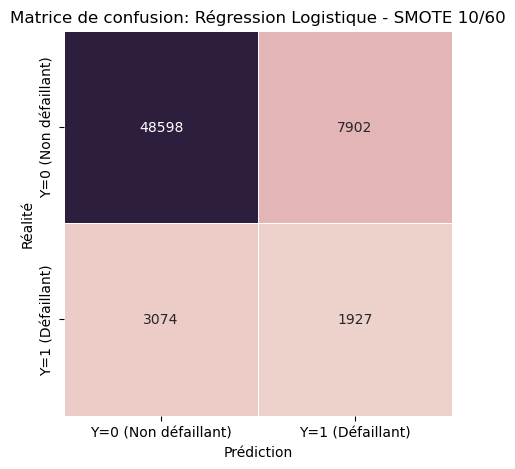

In [210]:
matrice_confusion(ytest = y_test,
                  ypred = y_pred_reglog_SMOTE1060,
                  model_name = reglog_smote_name1060)

Le choix du traitement du déséquilibre des classes par class weight balanced donnant les meilleurs résultats, nous partirons de cette méthode pour le prochain modèle: le LightGBM. Si nous avions choisi la méthode SMOTE, nous aurions vérifier la distribution de nos variables avant et après.

<div class="alert alert-block alert-success">
    <p>POURQUOI?</p>
</div>

### LightGBM <a class="anchor" id="lightgbm"></a>

Basé sur des algorithmes **d’arbre de décision**, LightGBM (Light Gradient Boosting Machine) est utilisé pour le classement, la classification et de nombreuses autres tâches de Machine Learning. C'est un algorithme développé par Microsoft et publié en 2016 qui est basé sur le **renforcement de gradient** (Gradient Boosting). 

L'objectif est de former plusieurs modèles utilisant le même algorithme d'apprentissage. Une **combinaison de modèles individuels simples** crée un **modèle plus fort et puissant**.

- Création d'un **modèle simple** qui est entrainé sur les données.
- Un **second modèle** est construit pour tenter de **corriger les erreurs** présentes dans le premier modèle. Les erreurs sont minimisées par l’algorithme de descente de gradient. Chaque arbre ajouté va compenser les erreurs commises précédemment **sans détériorer les prédictions qui ont été justes**. La base d'apprentissage estdifférente.
- Cette procédure se poursuit et des modèles sont ajoutés jusqu’à ce que l’ensemble complet des données de formation soit prédit correctement ou que le nombre maximal de modèles soit ajouté.
- Les prédictions du dernier modèle ajouté seront les prédictions globales fournies par les anciens modèles d’arbres.

https://blent.ai/blog/a/lightgbm-mieux-que-xgboost

Cet algorithme offre de très bonnes performances et nous permettra d'analyser l'importance des variables globales.

Lors de l'optimisation des hyperparamètres, nous tenterons un approche par GridSearchCV sur les hyperparamètres suivants:
- **n_estimators** = nombre d'arbres de décision (il est préférable d'en avoir plusieurs)
- **max_depth** = profondeur de chaque arbre qui contrôle le degré de spécialisation de chaque arbre par rapport à l'ensemble des données d'apprentissage (viser une profondeur modeste). Il existe deux façons principales de **contrôler la complexité des arbres** : la **profondeur maximale** des arbres et le **nombre maximal des feuilles** dans l'arbre.
- **learning_rate**: importance de la contribution de chaque modèle à la prédiction de l'ensemble (taux plus faibles => plus d'arbres de décision)

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

https://machinelearningmastery.com/light-gradient-boosted-machine-lightgbm-ensemble/

#### Modélisation sur données rééquilibrées par class weight + hyperparameters tuning

In [211]:
lgb, lgb_params, lgb_name, lgb_duration = best_model(model_name = 'LightGBM',
                                                     model = LGBMClassifier(random_state = 42, class_weight='balanced'),
                                                     cv = KFold(n_splits = 5, shuffle = True, random_state = 42),
                                                     xtrain = X_train,
                                                     numeric_features = num_feat,
                                                     numeric_transformer = StandardScaler(),
                                                     ytrain = y_train,
                                                     params = {"classifier__ max_depth": [1, 2, 3],
                                                               "classifier__ n_estimators": [1, 2, 3],},
                                                     scoring = make_scorer(score_metier, greater_is_better=False),
                                                     xtest = X_test,
                                                     ytest = y_test,
                                                     oversampling_strategy = 0.1,
                                                     undersampling_strategy = 0.5,
                                                     balanced = False,
                                                     Randomized = True)

C:\Users\milie\anaconda3\envs\projet7\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Warning] max_depth is set=-1, max_depth=1 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] num_iterations is set=100, n_estimators=1 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] max_depth is set=-1, max_depth=1 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] num_iterations is set=100, n_estimators=1 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] max_depth is set=-1, max_depth=1 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] num_iterations is set=100, n_estimators=1 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] max_depth is set=-1, max_depth=1 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] num_iterations is set=100, n_estimators=1 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] max_depth is set=-1, max_depth=1 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] num_iterations is set=100, n

[LightGBM] [Warning] max_depth is set=-1, max_depth=3 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] num_iterations is set=100, n_estimators=3 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] max_depth is set=-1, max_depth=3 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] num_iterations is set=100, n_estimators=3 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] max_depth is set=-1, max_depth=3 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] num_iterations is set=100, n_estimators=3 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] max_depth is set=-1, max_depth=3 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] num_iterations is set=100, n_estimators=3 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] max_depth is set=-1, max_depth=3 will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] num_iterations is set=100, n

In [184]:
lgb_params

{'classifier__solver': 'saga',
 'classifier__penalty': 'l2',
 'classifier__C': 0.01}

In [212]:
# Evaluation sur les données de test
(biz_lgb, beta_lgb, rec_lgb, prec_lgb,
 acc_lgb, auc_lgb, y_pred_lgb) = fct_model.eval_metrics(best_model = lgb,
                                                                    xtest = X_test,
                                                                    ytest = y_test,
                                                                    beta_value = 2)

Score métier: 52676
Beta score: 0.39625377940561923
Recall: 0.6446710657868426
Precision: 0.15592203898050974
Accuracy: 0.6873221573632949
AUC: 0.667884205459793


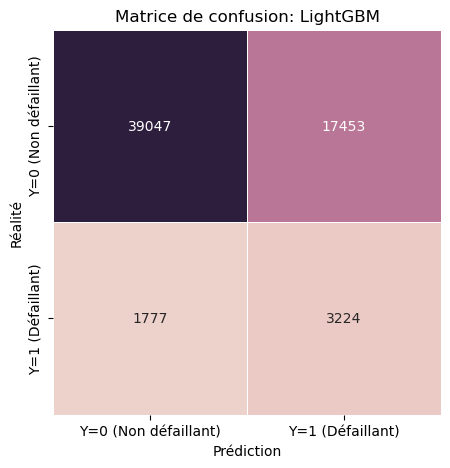

In [213]:
matrice_confusion(ytest = y_test,
                  ypred = y_pred_lgb,
                  model_name = lgb_name)

#### Choix du beta

#### Features importances globales

#### Features importances locales

In [ ]:
lgb_smote1, df_lgb_smote1 = best_model(model_name = 'LightGBM',
                                    model = LGBMClassifier(random_state = 42, verbose = -1),
                                    xtrain = X_train,
                                    numeric_features = feats,
                                    numeric_transformer = StandardScaler(),
                                    ytrain = y_train,
                                    params = {"classifier__ max_depth": [1, 2, 3],
                                              "classifier__ n_estimators": [1, 2, 3],},
                                    scoring = make_scorer(score_metier),
                                    xtest = X_test,
                                    ytest = y_test,
                                    oversampling_strategy = 0.1, undersampling_strategy = 0.5, balanced = True)

In [ ]:
lgb_smote1, df_lgb_smote1 = best_model(model_name = 'LightGBM',
                                    model = LGBMClassifier(random_state = 42),
                                    xtrain = X_train,
                                    numeric_features = feats,
                                    numeric_transformer = StandardScaler(),
                                    ytrain = y_train,
                                    params = {"classifier__ max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                                              "classifier__ num_leaves": [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024],
                                              "classifier__ learning_rate": [0.0001, 0.001, 0.01, 0.1, 1.0],
                                              "classifier__ n_estimators": [10, 50, 100, 500, 1000, 5000],},
                                    scoring = make_scorer(score_metier),
                                    xtest = X_test,
                                    ytest = y_test,
                                    oversampling_strategy = 0.1, undersampling_strategy = 0.5, balanced = True)

In [ ]:
lgb_smote1, df_lgb_smote1 = best_model(model_name = 'LightGBM',
                                    model = LGBMClassifier(random_state = 42, verbose = -1),
                                    xtrain = X_train,
                                    numeric_features = feats_lgb,
                                    numeric_transformer = StandardScaler(),
                                    ytrain = y_train,
                                    params = {"classifier__ max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                                              "classifier__ num_leaves": [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024],
                                              "classifier__ learning_rate": [0.0001, 0.001, 0.01, 0.1, 1.0],},
                                    scoring = make_scorer(score_metier),
                                    xtest = X_test,
                                    ytest = y_test,
                                    oversampling_strategy = 0.1, undersampling_strategy = 0.5, balanced = True)

In [ ]:
params = {"classifier__ num_iterations": [10, 50, 100, 500, 1000, 5000],
                                              "classifier__ max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                                              "classifier__ num_leaves": [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024],
                                              "classifier__ learning_rate": [0.0001, 0.001, 0.01, 0.1, 1.0],},

### Choix du meilleur modèle <a class="anchor" id="eval"></a>

In [ ]:
lgb_smote1.get_params

In [ ]:
#EXPERIMENT_NAME = "mlflow-default-risk"
#EXPERIMENT_ID = mlflow.create_experiment(EXPERIMENT_NAME)

start_Dummy = time.time()
model = DummyClassifier()

# Sélection des hyperparamètres
params = {'strategy' : ['most_frequent', 'prior', 'stratified', 'uniform'],}
scoring = make_scorer(recall_score)

best_model_Dummy, best_params_Dummy = optimize_and_train_model(pipeline_model = model,
                                                                xtrain = X_train,
                                                                ytrain = y_train,
                                                                params = params,
                                                                scoring = scoring)


duration_Dummy = time.time() - start_Dummy
    
# Evaluation du modèle
(recall, precision, accuracy, auc) = eval_metrics(best_model = best_model_Dummy,
                                                    xtest = X_test,
                                                    ytest = y_test)
    
print(f"DummyClassifier Model with param strategy = {best_params_Dummy['strategy']}")
print()
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"AUC: {auc:.2f}")
print(f"Train time: {duration_Dummy:.2f}")

# Start MLflow
with mlflow.start_run() as run:
#with mlflow.start_run(experiment_id=EXPERIMENT_ID, run_name=RUN_NAME) as run:
    
    # Run id
    RUN_ID = run.info.run_id
    
    # log des paramètres et scores à chaque fois que le modèle est lancé
    mlflow.log_param("strategy", best_params_Dummy['strategy'])
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("auc", auc)
    mlflow.log_metric("Tps_entrainement", duration_Dummy)
    
    mlflow.sklearn.log_model(best_model_Dummy, "dummyclassifier")

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html

https://datascience.stackexchange.com/questions/82780/how-to-implement-a-gridsearchcv-custom-scorer-that-is-dependent-on-a-training-fe

<div class="alert alert-block alert-success">
    <p>•	Finir la partie exploration et la transformation et choix des features 
•	Créer un environnement MLFlow permettant le tracking lors de l’entraînement des modèles, la visualisation et la comparaison via l’UI de MLFlow, ainsi que le stockage de manière centralisée des modèles.
o	Il faut au minimum le tracking des scores (scores métier, AUC), des hyperparamètres, des temps de traitement de fit et de prédiction, ainsi que le stockage de graphiques (ROC curve) et des modèles
•	Une fonction de tracking de logs 

Bonus (je te le mets pour que tu l'aies en tête mais je n'attends pas que tu le fasse tout de suite) :
•	Avant de construire les modèles, réfléchir à la fonction de coût métier : 
o	La problématique « métier » est de prendre en compte qu’un faux positifs (crédit non accordé à tort, donc manque à gagner de la marge pour la banque) n’a pas le même coût qu’un faux négatif (mauvais client à qui on accorde un prêt, donc perte sur le capital non remboursé). Un faux négatif est environ 10 fois plus coûteux qu’un faux positif. Les mesures techniques tels que le f1 score ne le prennent pas en compte.
o	Le score “métier” consiste à calculer une fonction de coût métier de type 10*FN + FP 
o	Les modèles et leur hyperparamètres seront optimisés via un GridSearchCV ou équivalent sur ce score, faire aussi l’accuracy ou l’AUC comme élément de comparaison (le garder en référence)
</p>
</div>

<div class="alert alert-block alert-warning">
    <p>Suppression des variables avec 30% ou plus de NaN</p>
</div>

In [ ]:
X_train_kb_X2_15 = pipeline.transform(X_train[categ_feat])
X_test_kb_X2_15 = pipeline.transform(X_test[categ_feat])

# Liste des 15 variables catégorielles conservées lors du SelectKBest
feats_kb_X2_15 = pipeline.get_feature_names_out().tolist()

# Score des 15 features
score_kb_X2_15 = sorted(fs.scores_, reverse=True)[0:15]

# Dataframe
dic_Chi2 = {'Features': feats_kb_X2_15,
            'Chi2_Score':score_kb_X2_15,}
df_Chi2 = pd.DataFrame(data = dic_Chi2)

In [ ]:
#pipeline.transform(X_train[categ_feat])
#pipeline.transform(X_test[categ_feat])

In [ ]:
plt.figure(figsize=(8,5))
plt.title('SelectKBest = 15')
plt.xticks(rotation=45, ha='right')
sns.barplot(data = df_Chi2, x = 'Chi2_Score', y = 'Features', palette='Purples_r');

In [ ]:
# Pipeline + entrainement avec sélection des 15 features
preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(), categ_feat)])
fs = SelectKBest(score_func = chi2, k = 15)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('feat_select',fs)])

pipeline.fit(X_train[categ_feat], y_train)

#X_train_kb_X2_15 = pipeline.transform(X_train[categ_feat])
#X_train_kb_X2_15 = pipeline.transform(X_test[categ_feat])

y_pred = pipeline.predict(X_test[categ_feat])
score_biz = score_metier(y_test, y_pred)
print(f'Score metier: {score_biz}')

In [ ]:
ratio à mettre en catégories: enx: tx endettement >33% etc

In [ ]:
# Pipeline + entrainement
preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(), categ_feat)],
                                 remainder='drop')
transform = VarianceThreshold(0.05)
fs_categ = SelectKBest(score_func = chi2, k = 'all')

pipeline = Pipeline(steps=[('ohe', preprocessor),
                           ('varthresh',transform),
                           ('feat_select',fs_categ)])

pipeline.fit(X_train, y_train)

In [ ]:
Nous allons ici sélectionner nos features par **RFE** (élimination récursive des caractéristiques) qui est une méthode wrapper.
Il existe 2 hyperparamètres:
- le choix du **nombre de features** à sélectionner 
- le choix de l'**algorithme** à utiliser

Ces deux hyperparamètres peuvent être explorés, bien que la performance de la méthode ne dépende pas fortement de ces hyperparamètres.

Le RFE va rechercher un **sous ensemble optimal de features** en commençant par les prendre toutes puis en les supprimant au fur et à mesure jusqu'à ce qu'il en reste le nombre souhaité. Le RFE va classer les caractéristiques en fonction de leur importance, écarter les moins importantes puis réajuster le modèle.

Nous allons utiliser un DecisionTreeClassifier pour choisir les caractéristiques et fixer le nombre de caractéristiques à 15. Nous allons évaluer le modèle à l'aide d'une validation croisée stratifiée k-fold répétée, avec cinq répétitions et 10 plis. Nous
Nous indiquerons la moyenne et l'écart-type de la précision du modèle pour l'ensemble des répétitions et des plis.
plis. L'exemple complet est présenté ci-dessous

In [ ]:
# Evaluation du modèle sur les données de test
    (score_biz, recall, precision, accuracy, auc, y_pred) = eval_metrics(
        best_model = best_model,
        xtest = xtest[numeric_features],
        ytest = ytest)
    

    matrice_confusion(ytest, y_pred, model_name)
    
    # Récap
    dic_df_recap = {'Modèle':[model_name],
                    'Features':[numeric_features],
                    'Best_Params':[best_params],
                    'Score_metier':[score_biz],
                    'Recall':[recall], 
                    'Precision':[precision], 
                    'Accuracy':[accuracy], 
                    'AUC':[auc], 
                    "Train_Time": [duration],}
    df_recap = pd.DataFrame(data = dic_df_recap)
    display(df_recap)
    
    return best_model, df_recap